In [1]:
from PEPit import PEP
from PEPit.operators import MonotoneOperator
from PEPit.primitive_steps import proximal_step
import numpy as np
from PEPit.function import Function
import matplotlib.pyplot as plt
import copy
import math
import time
import scipy
from pathlib import Path
import scipy.io
import seaborn as sns
import cvxpy as cp

# !pip install mosek

import cvxopt

%matplotlib inline

In [2]:

def GDA(mu,L,eta,anchored = False, verbose = 1, alt = True ):
    # notations
    n_iter = 2
    n_points = n_iter + 1 ## Correspond to 1 iteration with two iterates

    dimG = 2*n_points **2
    # nbPtsA = 2*n_iter + 1 # 



    # 
    xs  = np.zeros((2, 1, dimG)) # this is x_* and y_*

    xk  = np.zeros((2, n_iter, dimG))
    gxk = np.zeros((2, n_points, n_points, dimG))
    Lk = np.zeros((2,n_points, n_points, n_points**2-1))

    x_anchor = xk[0,0,:].copy()
    y_anchor = xk[1,0,:].copy()

    k=0
    for p in range(2):
        for i in range(n_points):
            for j in range(n_points):
                if i == j ==0:
                    xk[p,i,k] = 1
                elif p == 0:
                    gxk[p,i,j,k] = 1
                    Lk[p,i,j,k-1] = 1
                    Lk[1-p,j,i,k-1] = -1
                else:
                    gxk[p,i,j,k] = -1
                k += 1

    assert(k==2*n_points**2)  


    for i in range(n_iter-1):


        if alt:
            # gamma = 1/(i+1)
            # # xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:]
            # # xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+1,i+2,:]
            # xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:] - gamma*(xk[0,i,:] - x_anchor)
            # xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+1,i+2,:] - gamma*(xk[1,i,:] - y_anchor)

            if anchored == True:
                gamma = 1/(i+25)
                xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:] - gamma*(xk[0,i,:] - x_anchor)
                xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+1,i+2,:] - gamma*(xk[1,i,:] - y_anchor)
            
            elif anchored == False:
                xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:]
                xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+1,i+2,:]
        
        else:
#             xk[i+1,:] = xk[i,:] - eta * gxk[i+1,i+1,:]
            xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+2,i+2,:]
#             yk[i+1,:] = yk[i,:] + eta * gyk[i+1,i+1,:]
            xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+2,i+2,:]
#     print(xk[1,:])
        

    # regroup all points to be interpolated in larger matrices
    XX_A = np.concatenate((xs,xk), axis=1)
    GX_A = gxk
    LL_A = Lk
    
    ## SDP part
    nbPtsA = n_points**2
    lambda_conv = {}
    lambda_smooth = {}
    lambda_lip_xy = {}
    for p in range(2):
        for j in range(n_points):
            lambda_conv[p,j] = cp.Variable((n_points, n_points), symmetric=False)
            for i in range(n_points):
                lambda_smooth[i,j,p] = cp.Variable((n_points, n_points), symmetric=False)

    lambda_L = cp.Variable((n_points, n_points))

    lambda_d0 = cp.Variable((1,1), symmetric=False)




    d_k_x = XX_A[0,2,:] 
    d_k_y = XX_A[1,2,:] 
#     C = np.outer(d_k_y,d_k_y)
    C = np.outer(d_k_x,d_k_x) + np.outer(d_k_y,d_k_y)

    cons_SDP = -C
    cons = []
    cons_L = 0
    # l_zeros = []
    # l_zeros = [(0,0,0,0),(0,0,0,1),(0,0,1,0),(0,0,1,1),(0,0,1,2),(0,0,0,2),(0,0,2,1),(0,0,2,2)]
    # l_zeros += [(0,1,0,0),(0,1,0,1),(0,1,0,2),(0,1,1,0),(0,1,1,1),(0,1,1,2),(0,1,2,0),(0,1,2,1),(0,1,2,2)]
    # l_zeros += [(0,2,0,0),(0,2,0,2),(0,2,1,0),(0,2,1,1),(0,2,2,0),(0,2,2,1),(0,2,2,2)]
    # l_zeros += [(1,0,0,0),(1,0,0,1),(1,0,0,2),(1,1,1,0),(1,0,1,1),(1,0,2,1),(1,0,2,2)]
    # l_zeros += [(1,1,0,0),(1,1,0,1),(1,1,0,2),(1,1,1,0),(1,1,1,1),(1,1,1,2),(1,1,0,2),(1,1,2,1),(1,1,2,2)]
#     l_zeros += [(1,2,0,0),(1,2,1,0),(1,2,1,1),(1,2,1,2),(1,2,2,0),(1,2,2,1),(1,2,2,2)]
    # Lip + strong conv between (x_i,y_i) and (x_j,y_i)
    for p in range(2):
        for i_x in range(n_points):
            for j_x in range(n_points): 
                for i_y in range(n_points):
                    if i_x != j_x:
                        xi = XX_A[p,i_x,:]
                        xj = XX_A[p,j_x,:]
                        gxj = GX_A[p,j_x, i_y, :]
                        Li = LL_A[p,i_x,i_y,:] 
                        Lj = LL_A[p,j_x,i_y,:]
                        A = np.outer(gxj,xi - xj) + mu/2 * np.outer(xi-xj,xi-xj) 
                        cons_SDP = cons_SDP + lambda_conv[p,i_y][i_x,j_x]*  A
                        cons_L = cons_L + lambda_conv[p,i_y][i_x,j_x]*(Li - Lj)
                    else:
                        cons += [lambda_conv[p,i_y][i_x,j_x]==0]

    for i_x in range(n_points):
        for j_x in range(n_points): 
            for i_y in range(n_points):
                for j_y in range(n_points):
                        if (i_x,i_y) != (j_x,j_y):
                            xi = XX_A[0,i_x,:]
                            xj = XX_A[0,j_x,:]
                            yi = XX_A[1,i_y,:]
                            yj = XX_A[1,j_y,:]
                            gxj = GX_A[0,j_x, j_y, :]
                            gyj = -GX_A[1,j_y, j_x, :]
                            Li = LL_A[0,i_x,i_y,:]
                            Lj = LL_A[0,j_x,j_y,:]
                            A = -np.outer(gxj,xi - xj) - np.outer(gyj,yi - yj) - L/2 * np.outer(xi-xj,xi-xj)
                            A -= L/2 * np.outer(yi-yj,yi-yj) 
                            cons_SDP = cons_SDP + lambda_smooth[i_x,i_y,0][j_x,j_y]*  A
                            cons_L = cons_L - lambda_smooth[i_x,i_y,0][j_x,j_y]*(Li - Lj)
                            A = np.outer(gxj,xi - xj) + np.outer(gyj,yi - yj) - L/2 * np.outer(xi-xj,xi-xj)
                            A -= L/2 * np.outer(yi-yj,yi-yj) 
                            cons_SDP = cons_SDP + lambda_smooth[i_x,i_y,1][j_x,j_y]*  A
                            cons_L = cons_L + lambda_smooth[i_x,i_y,1][j_x,j_y]*(Li - Lj)
                        else:
                            cons += [lambda_smooth[i_x,i_y,0][j_x,j_y]==0]
                            cons += [lambda_smooth[i_x,i_y,1][j_x,j_y]==0]

                    

                
    # Constraint for x_0 
    d_0_x = XX_A[0,1,:] 
    d_0_y = XX_A[1,1,:] 
    A = np.outer(d_0_x,d_0_x) + np.outer(d_0_y,d_0_y)
    cons_SDP += lambda_d0[0,0] * A 
    
    #add constraints
    for p in range(2):
        for j in range(n_points):
            cons += [lambda_conv[p,j] >= 0]
    for i in range(n_points):
        for j in range(n_points):
            for p in range(2):
                cons += [lambda_smooth[i,j,p] >= 0]
    cons += [lambda_d0[0,0] >= 0] 

    cons += [cons_SDP  >> 0]
    for i in range(nbPtsA-1):
            cons += [cons_L[i] == 0]

    # obj = lambda_d0[0,0] 
    
    d_1_x = XX_A[0,1,:] 
    d_1_y = XX_A[1,1,:] 
    d_2_x = XX_A[0,2,:] 
    d_2_y = XX_A[1,2,:] 

    numerator = cp.sum_squares(d_2_x) + cp.sum_squares(d_2_y)
    denominator = cp.sum_squares(d_1_x) + cp.sum_squares(d_1_y)

    r_squared = cp.Variable()
    cons += [numerator <= r_squared * denominator]

    obj = r_squared

    prob = cp.Problem(cp.Minimize(obj),cons)

    prob.solve(solver='MOSEK', verbose=verbose)
#     for lam in lambda_smooth_y.values():
#         print(lam.value)
    
    return prob.value, (lambda_conv, lambda_smooth)


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) May 03 03:23:57 PM: Your problem has 218 variables, 586 constraints, and 0 parameters.
(CVXPY) May 03 03:23:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 03 03:23:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 03 03:23:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 03 03:23:57 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 03 03:23:57 PM: Compiling problem (target solver=MOSEK).


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (15, 2) + inhomogeneous part.

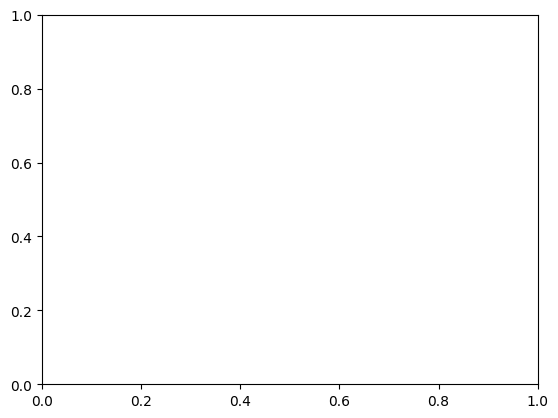

In [3]:
# Parameters for the experiment
L = 8.0
mu_values = np.linspace(0.1, 5, 15)  # varying mu to change kappa
eta = 1 / (2*L**2)

r_values = []
kappa_values = []

for mu in mu_values:
    kappa = L / mu
    solver_value = GDA(mu, L, eta, alt=True, anchored=True)
    r_values.append(solver_value)
    kappa_values.append(kappa)

# Plotting r vs. kappa
plt.plot(kappa_values, r_values, marker='o', linestyle='-', color='b')
plt.xlabel('Condition number (kappa)')
plt.ylabel('Convergence rate (r)')
plt.title('Convergence Rate vs Condition Number for alt-GDA')
plt.grid(True)
plt.show()

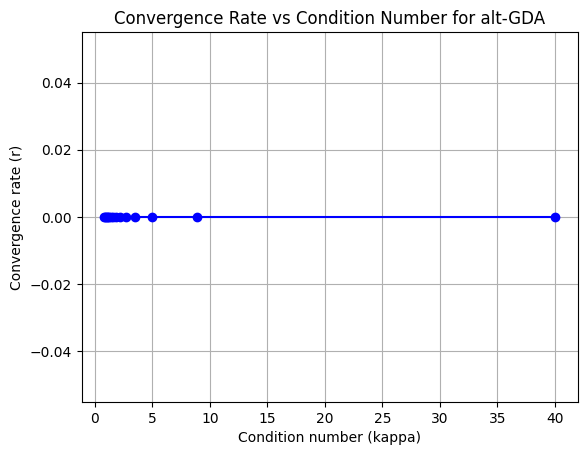

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def GDA(mu, L, eta, anchored=False, verbose=0, alt=True):
    n_iter = 2
    n_points = n_iter + 1

    dimG = 2*n_points **2

    xs = np.zeros((2, 1, dimG))

    xk = np.zeros((2, n_iter, dimG))
    gxk = np.zeros((2, n_points, n_points, dimG))
    Lk = np.zeros((2, n_points, n_points, n_points**2-1))

    x_anchor = xk[0, 0, :].copy()
    y_anchor = xk[1, 0, :].copy()

    k = 0
    for p in range(2):
        for i in range(n_points):
            for j in range(n_points):
                if i == j == 0:
                    xk[p, i, k] = 1
                elif p == 0:
                    gxk[p, i, j, k] = 1
                    Lk[p, i, j, k-1] = 1
                    Lk[1-p, j, i, k-1] = -1
                else:
                    gxk[p, i, j, k] = -1
                k += 1

    for i in range(n_iter-1):
        if alt:
            if anchored:
                gamma = 1/(i+20)
                xk[0, i+1, :] = xk[0, i, :] - eta * gxk[0, i+1, i+1, :] - gamma*(xk[0, i, :] - x_anchor)
                xk[1, i+1, :] = xk[1, i, :] - eta * gxk[1, i+1, i+2, :] - gamma*(xk[1, i, :] - y_anchor)
            else:
                xk[0, i+1, :] = xk[0, i, :] - eta * gxk[0, i+1, i+1, :]
                xk[1, i+1, :] = xk[1, i, :] - eta * gxk[1, i+1, i+2, :]

    XX_A = np.concatenate((xs, xk), axis=1)
    GX_A = gxk
    LL_A = Lk

    lambda_conv = {}
    lambda_smooth = {}
    for p in range(2):
        for j in range(n_points):
            lambda_conv[p, j] = cp.Variable((n_points, n_points))
            for i in range(n_points):
                lambda_smooth[i, j, p] = cp.Variable((n_points, n_points))

    lambda_d0 = cp.Variable((1, 1))

    d_k_x = XX_A[0, 2, :]
    d_k_y = XX_A[1, 2, :]
    C = np.outer(d_k_x, d_k_x) + np.outer(d_k_y, d_k_y)

    cons_SDP = -C
    cons = []
    cons_L = 0

    for p in range(2):
        for i_x in range(n_points):
            for j_x in range(n_points):
                for i_y in range(n_points):
                    if i_x != j_x:
                        xi = XX_A[p, i_x, :]
                        xj = XX_A[p, j_x, :]
                        gxj = GX_A[p, j_x, i_y, :]
                        Li = LL_A[p, i_x, i_y, :]
                        Lj = LL_A[p, j_x, i_y, :]
                        A = np.outer(gxj, xi - xj) + mu/2 * np.outer(xi-xj, xi-xj)
                        cons_SDP = cons_SDP + lambda_conv[p, i_y][i_x, j_x]*A
                        cons_L = cons_L + lambda_conv[p, i_y][i_x, j_x]*(Li - Lj)

    d_0_x = XX_A[0, 1, :]
    d_0_y = XX_A[1, 1, :]
    A = np.outer(d_0_x, d_0_x) + np.outer(d_0_y, d_0_y)
    cons_SDP += lambda_d0[0, 0] * A

    cons += [cons_SDP >> 0]
    cons += [lambda_d0[0, 0] >= 0]

    obj = lambda_d0[0, 0]
    prob = cp.Problem(cp.Minimize(obj), cons)

    prob.solve(solver='MOSEK', verbose=verbose)
    return prob.value


# Parameters for the experiment
L = 4
kappa = np.linspace(10, 1e2, 20)  # varying mu to change kappa
eta = 1 / (2*L**2)

r_values = []
kappa_values = []

for mu in mu_values:
    mu = L / kappa
    solver_value = GDA(mu, L, eta, alt=False, anchored=True)
    r_values.append(solver_value)
    kappa_values.append(kappa)

# Plotting r vs. kappa
plt.plot(kappa_values, r_values, marker='o', linestyle='-', color='b')
plt.xlabel('Condition number (kappa)')
plt.ylabel('Convergence rate (r)')
plt.title('Convergence Rate vs Condition Number for alt-GDA')
plt.grid(True)
plt.show()